In [13]:
#import libraries
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns


In [2]:
# read data
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data")
df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [3]:
#df.drop(['subject#','age','sex','test_time','motor_UPDRS'],'columns',inplace = True)

In [4]:
df.shape

(5875, 22)

In [5]:
#y = df['total_UPDRS']
#x = df.drop(['subject#','age','sex','test_time','motor_UPDRS','total_UPDRS'],'columns',inplace = True)



In [6]:
# Define the target and features:
target_label = 'total_UPDRS'
non_features = ['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS']
feature_labels = [x for x in df.columns if x not in [target_label] + non_features]

# Filter out non-features and non-targets
df = df.drop(non_features, axis=1)

# One-hot encode inputs
parkinsons_expanded = pd.get_dummies(df, drop_first=True)
print('DataFrame one-hot-expanded shape: {}'.format(parkinsons_expanded.shape))

# Get target and original x-matrix
y = df[target_label]
X = df.as_matrix(columns=feature_labels)

DataFrame one-hot-expanded shape: (5875, 17)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [7]:
#scale function
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col)/sd_col
    return std

In [9]:
x_scaled = np.apply_along_axis(scale,0,X)
y_scaled = np.apply_along_axis(scale,axis=0,arr=y)

In [10]:
# PCR
#Initialize PCA
pca = PCA()
pca_result = pca.fit_transform(x_scaled)
column_names = ['pc' + str(ix+1) for ix in range(x_scaled.shape[1])]
pca_df = pd.DataFrame(data=pca_result,columns = column_names)
pca_df[target_label] = y_scaled

Text(0, 0.5, 'Explained Variance')

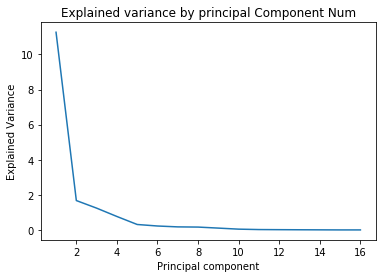

In [11]:
#scree plot for selecting principal components
plt.plot([i + 1 for i in range(16)],pca.explained_variance_)
plt.title('Explained variance by principal Component Num')
plt.xlabel('Principal component')
plt.ylabel('Explained Variance')

                            OLS Regression Results                            
Dep. Variable:            total_UPDRS   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     95.87
Date:                Tue, 06 Feb 2024   Prob (F-statistic):           2.21e-97
Time:                        01:51:39   Log-Likelihood:                -8105.6
No. Observations:                5875   AIC:                         1.622e+04
Df Residuals:                    5869   BIC:                         1.626e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.858e-16      0.013   2.28e-14      1.0

Text(0.5, 1.0, 'Residual Histogram')

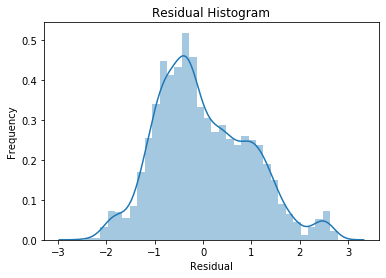

In [14]:
# Linear Reression with first N columns
n=5
formula_start = target_label + ' ~ '
formula_terms = ['pc' + str(x+1) for x in range(n)]
formula_end = ' + '.join(formula_terms)
formula_final = formula_start + formula_end
# Get linear model using ordinary least squares
pcr_model = sm.ols(formula = formula_final, data=pca_df)
# Fit linear model
results = pcr_model.fit()

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')